<a href="https://colab.research.google.com/github/stevengregori92/Learn-Polynomial-Regression/blob/main/Polynomial_Regression_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install luwiji

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

#Import Dataset

In [ ]:
data = pd.read_csv('taxi_fare.csv', parse_dates=['pickup_datetime'])
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0


,missing_value,%
fare_amount,0,0.00
pickup_datetime,0,0.00
pickup_longitude,0,0.00
pickup_latitude,0,0.00
dropoff_longitude,0,0.00
dropoff_latitude,0,0.00
passenger_count,1,0.01


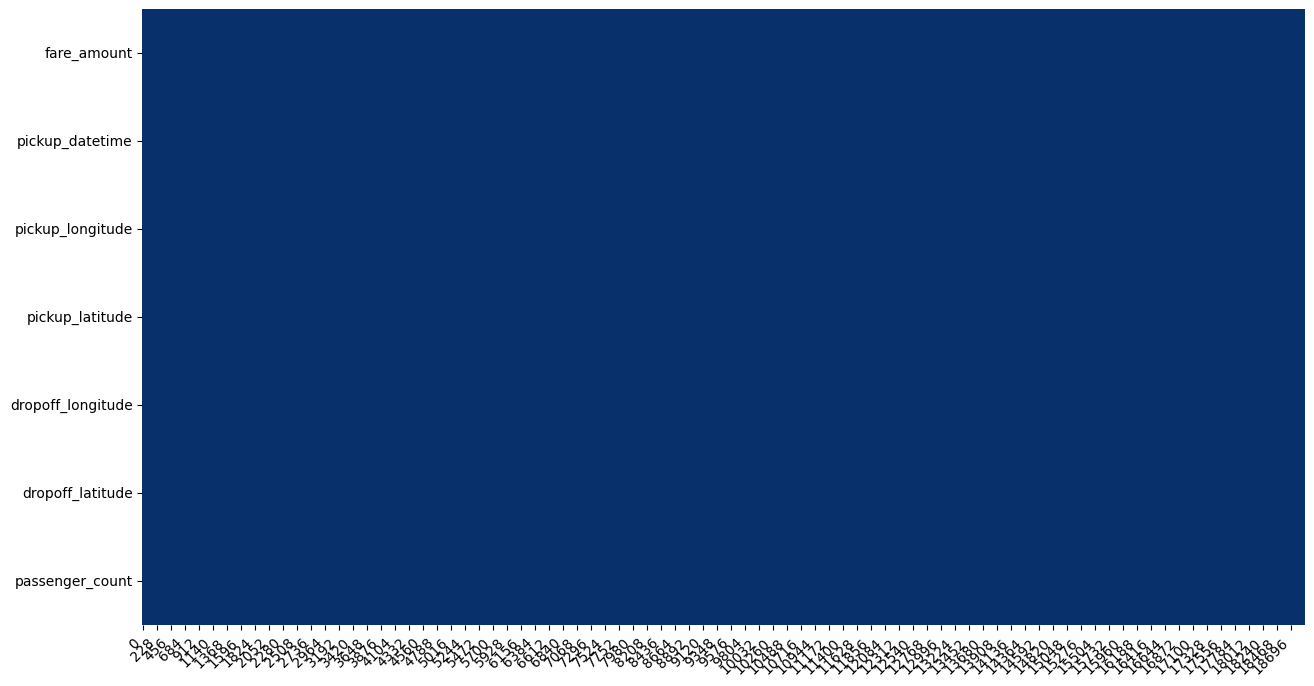

In [ ]:
plot_missing_value(data, return_df=True)

In [ ]:
data.dropna(inplace=True)

#Extract Time Feature

In [ ]:
pickup_dt = data.pickup_datetime.dt

In [ ]:
data['year'] = pickup_dt.year
data['month'] = pickup_dt.month
data['day'] = pickup_dt.dayofweek
data['hour'] = pickup_dt.hour
data.drop(columns='pickup_datetime', inplace = True)
data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,0,17
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,1,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,3,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,5,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,1,7


#Extract Distance Feature

In [ ]:
data['distance'] = np.abs(data.pickup_longitude - data.dropoff_latitude) + np.abs(data.pickup_latitude - data.dropoff_latitude)
data.drop(columns = ['pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], inplace=True)
data.head()

,fare_amount,passenger_count,year,month,day,hour,distance
0,4.5,1.0,2009,6,0,17,114.565630
1,16.9,1.0,2010,1,1,16,114.868753
2,5.7,2.0,2011,8,3,0,114.744008
3,7.7,1.0,2012,4,5,4,114.770171
4,5.3,1.0,2010,3,1,7,114.767611


#Dataset Splitting

In [ ]:
X = data.drop(columns='fare_amount')
y = data.fare_amount

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15134, 6), (3784, 6), (15134,), (3784,))

#Training

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [ ]:
gsp.linreg_params

{'algo__fit_intercept': [True, False]}

In [ ]:
X_train.head()

,passenger_count,year,month,day,hour,distance
7539,1.0,2011,6,1,22,0.000000
578,3.0,2010,3,3,10,114.691501
8056,5.0,2010,4,0,8,114.722660
11761,1.0,2014,11,0,22,114.782957
15531,1.0,2012,12,5,13,114.721999


In [ ]:
X_train.columns

Index(['passenger_count', 'year', 'month', 'day', 'hour', 'distance'], dtype='object')

In [ ]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ['passenger_count', 'year', 'distance']),
    ('categoric', cat_pipe(encoder='onehot'),['month', 'day', 'hour'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LinearRegression())
])

model = GridSearchCV(pipeline, gsp.linreg_poly_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'algo__fit_intercept': True, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': True}
0.022865002782710198 0.015605993290056594 0.01911885014800363


#Feature Importance

Jangan harap feature importance, nilainya masih jelek

#Evaluation

Actual vs Prediction

In [ ]:
from jcopml.plot import plot_actual_vs_prediction, plot_residual

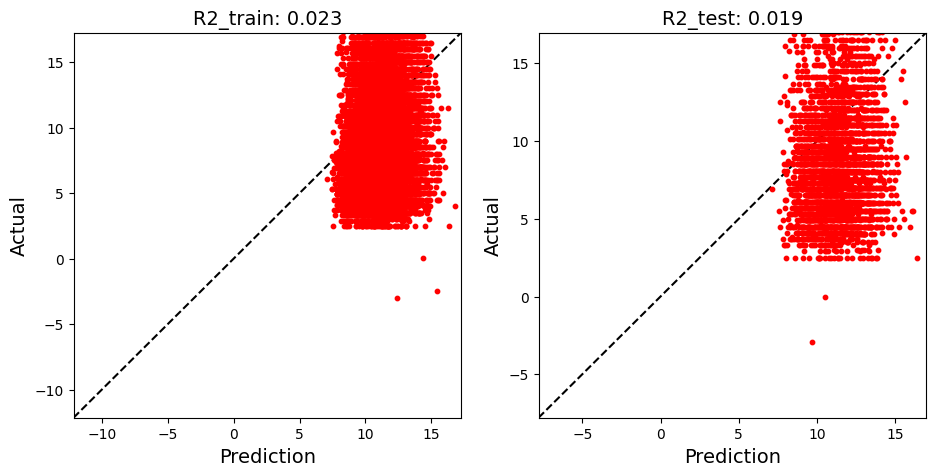

In [ ]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

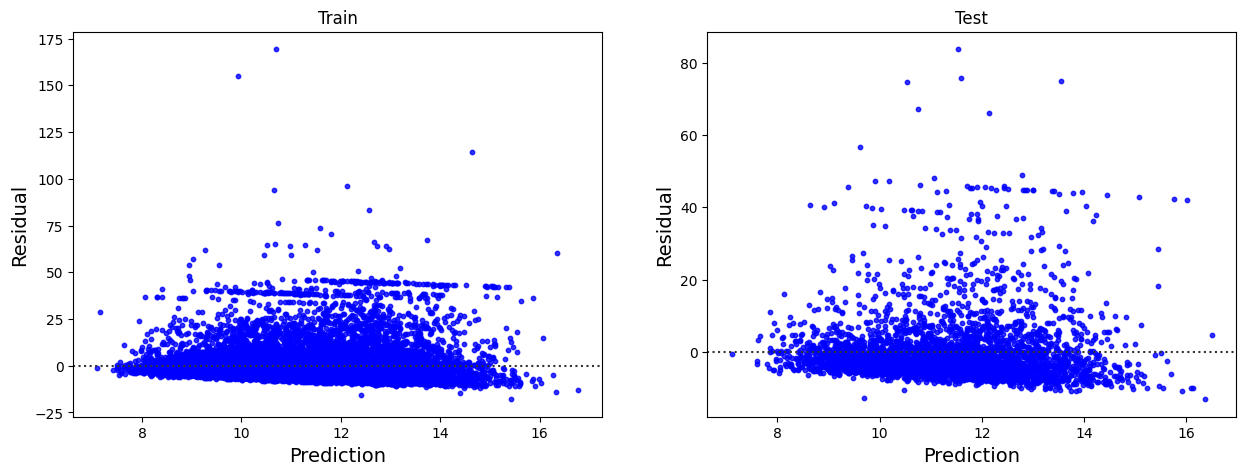

In [ ]:
plot_residual(X_train, y_train, X_test, y_test, model)

#Transform

In [ ]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2, transform = 'yeo-johnson'), ['passenger_count', 'year', 'distance']),
    ('categoric', cat_pipe(encoder='onehot'),['month', 'day', 'hour'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LinearRegression())
])

model = GridSearchCV(pipeline, gsp.linreg_poly_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'algo__fit_intercept': False, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': True}
0.008597228515074273 -48137014.29015052 0.007847450292765235


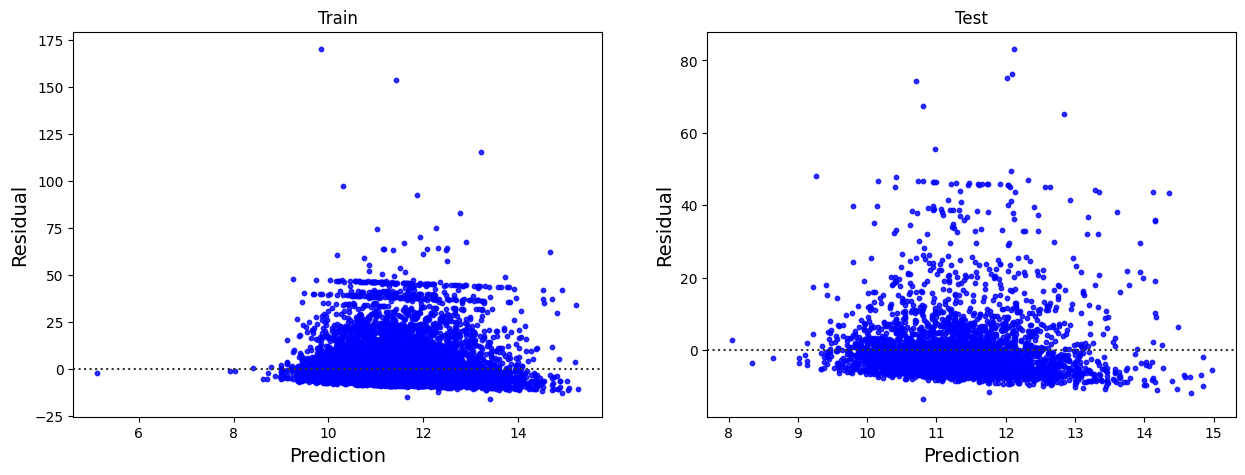

In [ ]:
plot_residual(X_train, y_train, X_test, y_test, model)